In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing all the libraries

In [0]:
import pandas as pd
import numpy as np
import datetime as datetime
import missingno as msno

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,classification_report
from sklearn.utils import resample, shuffle
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)
import xgboost
from datetime import datetime,date,time
import calendar

from keras import Sequential
from keras.layers import Dense
from keras.utils import np_utils

import tensorflow as tf
from tensorflow.python.keras.metrics import Precision, Recall


Reading visit file as a pandas dataframe. The index is the row count of all the data in the visit csv file. There are a total of 178356 instances available

In [0]:
df = pd.read_csv('/content/drive/My Drive/AI/visits_full.csv',index_col='Unnamed: 0')

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Checking for duplicate records in the file. After runing the code we find no duplicate records.

In [0]:
df[df.duplicated(subset=None,keep='first')]

,Visit_ID,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time


Now sorting the dataframe by DateTime, Customer ID and Sequence Number. This will allow us to see how a unique customer on a specfic day went about his day in a mall. Increase in sequence number for a Customer ID means that the customer went to more than one store in a day  

In [0]:
df.sort_values(by=['DateTime','Customer_ID','Sequence_Num']).head(15)

,Visit_ID,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time
1,1,2018-01-01 06:00:30,1,0,5079483,56
2,2,2018-01-01 06:00:30,1,3,5163263,201
3,3,2018-01-01 06:04:50,2,0,3,40
4,4,2018-01-01 06:46:50,3,1,5152724,10
5,5,2018-01-01 06:46:50,3,3,5079580,73
6,6,2018-01-01 07:28:20,4,2,2,168
7,7,2018-01-01 07:50:40,5,1,4,39
8,8,2018-01-01 07:56:50,6,1,3,27
9,9,2018-01-01 07:56:50,6,4,5080089,6
10,10,2018-01-01 08:28:40,7,3,2,9


The sequence number are not incrementing by 1. We know that during the data cleaning exercise any visit less than 5 minutes was removed from the dataframe. This resulted in sequence numbers not incrementing consistently. We will fix this issue by making sure that every incremental visit increments by +1 

In [0]:
df['Sequence_Num'] = df.groupby(['DateTime','Customer_ID']).cumcount() + 1

Now just exploring Customer ID 9, 10 & 11 to see if the Sequence_Num are incrementing as expected. Customer_ID 9 goes to 5 stores on 2018-01-01 and as a result Sequence number increments by + 1 until 5. At this point a new Customer_ID 10 comes in and the Sequence resets to 1. Similarly for Customer_ID 11 where he visits 2 stores. 

We were able to achieve this by grouping Customer ID and DateTime by Cumalative count. This groupby functionality increases the count by +1 for every unique Date and Customer_ID combination

In [0]:
df[(df['Customer_ID']==9) | (df['Customer_ID']==10) | (df['Customer_ID']==11)]

,Visit_ID,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time
12,12,2018-01-01 08:52:00,9,1,5079256,58
13,13,2018-01-01 08:52:00,9,2,5079256,8
14,14,2018-01-01 08:52:00,9,3,5079256,17
15,15,2018-01-01 08:52:00,9,4,3,7
16,16,2018-01-01 08:52:00,9,5,5079256,10
17,17,2018-01-01 08:58:20,10,1,5080089,7
18,18,2018-01-01 09:00:50,11,1,5080089,6
19,19,2018-01-01 09:00:50,11,2,9713461,15


Droping Visit_ID as it provides no additional explanation.


In [0]:
df = df.drop(labels=['Visit_ID'],axis=1)
df['DateTime'] = pd.to_datetime(df['DateTime'])  #Converting column DateTime which is a str to datetime 
df['Day'] = df['DateTime'].dt.weekday   # Extracting Day as a new feature from DateTime
df['Month'] = df['DateTime'].dt.month   # Extracting Month as a new feature from DateTime    

Check for any Null value and return the sum of the total value missing in each column

In [0]:
df.isnull().values.any()
df.isnull().sum()

DateTime        3
Customer_ID     0
Sequence_Num    0
Store_ID        0
Dwell_Time      0
Day             3
Month           3
dtype: int64

In [0]:
df[df['Month'].isna()] # returns all the Null values in the dataset

,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time,Day,Month
1500432,NaT,464411,1,5080126,8,NaN,NaN
1500433,NaT,464411,2,9474122,6,NaN,NaN
1500434,NaT,464411,3,9713461,7,NaN,NaN


In [0]:
df.drop(index =[1500432,1500433,1500434],axis=0,inplace=True) #Droping the Null values from the dataset

Now we will create the Target for each row. The Target label we need to predict is the next store the customer will visit. This means each subsequent row for a unique Customer_ID is the target class. We will do this by first sorting the dataframe by DateTime, Customer ID and Sequence Number. We will then create 2 new columns to track the nex sequence and next store for a unique customer

In [0]:
df = df.sort_values(by=['DateTime','Customer_ID','Sequence_Num']) #sorts the dataframe by DateTime, Customer_ID and Sequence_Num
df['Next_Sequence'] = df['Sequence_Num'].shift(-1) #Creates a new column called Next_Sequence by shifting Sequence_Num by 1
df['Target'] = df['Store_ID'].shift(-1) #Creates a new column called Next_Store by shifting Store_ID column by 1
df.drop(index=1783546,axis=0,inplace=True)

Now lets look at Custome_ID 9 and observe how the Next Sequence and Next Store changes as he goes from one store to the other. Now as you for row 12 Sequence number is 1 and Next_sequence is 2. Similarly for row 13 we see Sequence_Num is 2 and Next_sequence is 3 and it goes on until row 16 where Sequence_Num is 5 but the Next_sequence is 1. This indicates that the Customer has left the mall

In [0]:
df[(df['Customer_ID']==9) | (df['Customer_ID']==10) | (df['Customer_ID']==11)]

,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time,Day,Month,Next_Sequence,Target
12,2018-01-01 08:52:00,9,1,5079256,58,0.0,1.0,2.0,5079256.0
13,2018-01-01 08:52:00,9,2,5079256,8,0.0,1.0,3.0,5079256.0
14,2018-01-01 08:52:00,9,3,5079256,17,0.0,1.0,4.0,3.0
15,2018-01-01 08:52:00,9,4,3,7,0.0,1.0,5.0,5079256.0
16,2018-01-01 08:52:00,9,5,5079256,10,0.0,1.0,1.0,5080089.0
17,2018-01-01 08:58:20,10,1,5080089,7,0.0,1.0,1.0,5080089.0
18,2018-01-01 09:00:50,11,1,5080089,6,0.0,1.0,2.0,9713461.0
19,2018-01-01 09:00:50,11,2,9713461,15,0.0,1.0,1.0,3.0


The following code will put a 0 in the Target column as the customer leaves the store. I can do this by checking if the Sequence_Num is greater than Nex_Store. If i find such a record that means that the customer has exited the store.

In [0]:
df['Target']=df['Target'].astype(int)  # Converting float to integer
df['Target']= np.where(df['Sequence_Num']>=df['Next_Sequence'],0,df['Target']) 

Now just looking at the same scenrio again. We see that in row 16. Target has been changed to 0 indicating customer leaving the store at that point. Customer 10 only goes to one store and therefore he has only one instance with the Target as zero. Customer 11 goes to 2 stores.

In [0]:
df[(df['Customer_ID']==9) | (df['Customer_ID']==10) | (df['Customer_ID']==11)]

,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time,Day,Month,Next_Sequence,Target
12,2018-01-01 08:52:00,9,1,5079256,58,0.0,1.0,2.0,5079256
13,2018-01-01 08:52:00,9,2,5079256,8,0.0,1.0,3.0,5079256
14,2018-01-01 08:52:00,9,3,5079256,17,0.0,1.0,4.0,3
15,2018-01-01 08:52:00,9,4,3,7,0.0,1.0,5.0,5079256
16,2018-01-01 08:52:00,9,5,5079256,10,0.0,1.0,1.0,0
17,2018-01-01 08:58:20,10,1,5080089,7,0.0,1.0,1.0,0
18,2018-01-01 09:00:50,11,1,5080089,6,0.0,1.0,2.0,9713461
19,2018-01-01 09:00:50,11,2,9713461,15,0.0,1.0,1.0,0


Now removing a few outliers in the data set

1.   Removing all records where we see customers before opening hours of the mall
2.   Removing all records where we see customers after the closing hours of the mall

3.   Removing all records where the Dwell time spent in a Store is more than 3 hours



In [0]:
df['Time'] = [datetime.time(d) for d in df['DateTime']] # Create a new column called Time
df = df[df['Time'] > time(10, 0, 0)] # Remove all records less than 10AM
df = df[df['Time'] < time(21,0,0) ] # Remove all records greater than 9PM
df =  df[df['Dwell_Time'] < 180] # Remove all records where Dwell time is more than 3 hours

Now bringing in other dataset to create more features for our experiment.Now bringing in the categories for each store

In [0]:
df_cat = pd.read_csv('/content/drive/My Drive/AI/stores.csv')

The dataset has a few discrepencies. In the following example all of Holt Renfrew's stores are being tracked with the same Store_ID. There are more of such casses as seen below

In [0]:
df_cat[df_cat.duplicated(subset=['Store_ID'] , keep = False)]

,Store_ID,Category_ID,Category_name,Name,Slot
19,5079256,8,Large Format,Holt Renfrew,3
20,5079256,8,Large Format,Holt Renfrew Louis Vuitton,3
21,5079256,8,Large Format,Holt Renfrew Prada,3
22,5079256,8,Large Format,Holt Renfrew Gucci,3
23,5079256,8,Large Format,Holt Renfrew Men,3
24,5079256,8,Large Format,Holt Renfrew Chanel,3
25,5079256,8,Large Format,Holt Renfrew Corridor 1,3
26,5079256,8,Large Format,Holt Renfrew Corridor 2,3
27,5079256,8,Large Format,Holt Renfrew Corridor 3,3
28,5079256,8,Large Format,Holt Renfrew Corridor Washrooms,3


In [0]:
df_cat.drop(df_cat[df_cat.duplicated(subset=['Store_ID'] , keep='first')].index, axis=0 , inplace = True) # Removing all records where unique Store_ID has multiple instances

In [0]:
df_cat.drop(columns=['Category_name','Name','Slot'],axis=1,inplace=True) # Droping all non-numerical coloumns

Combining dataframes together. The resulting dataframe will now contain a new column that will track the category of the store

In [0]:
df = df.merge(df_cat,how='inner', on='Store_ID') # Doing an inner join on Store_ID between df and df_cat

Now lets plot the data for all the stores based on the number of times it is visited. The data distribution is highly skewed with 'Exit Store' dominating over the entire data

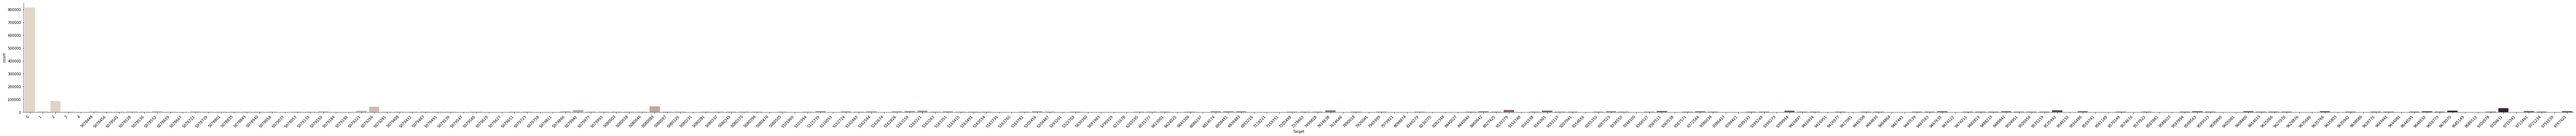

In [0]:
ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=df,height=5, aspect=20)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

Now plotting the data without taking exit into account and arranding it by descending order to get an overall picture

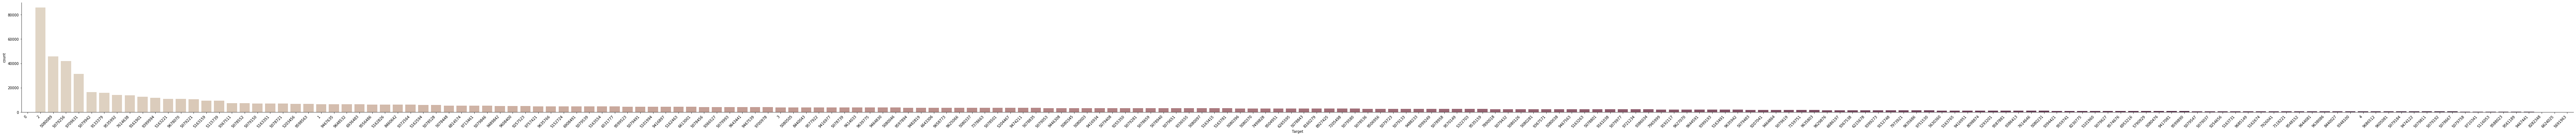

In [0]:
ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=df[df['Target']!=0],height=5, aspect=20,order=df['Target'].value_counts().index,)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

Creating a new dataFrame which will not contain any exits from the mall

In [0]:
df_no_exit = df[df['Target']!=0]

Taking the Top 5 stores by the total number of visits and bucketing the rest of the stores as 0

In [0]:
def conditions(x):
    if x == 2:
        return 2
    elif x == 5080089:
        return 5080089
    elif x == 5079256:
      return 5079256
    elif x == 9709631:
      return 9709631
    elif x == 5079942:
      return 5079942
    else:
        return 0

func = np.vectorize(conditions)
New_Stores = func(df_no_exit["Store_ID"])
New_Target = func(df_no_exit["Target"])
df_no_exit['Store_ID'] = New_Stores
df_no_exit['Target'] = New_Target

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Plotting graph to see the actual distribution based on the new bucketing logic

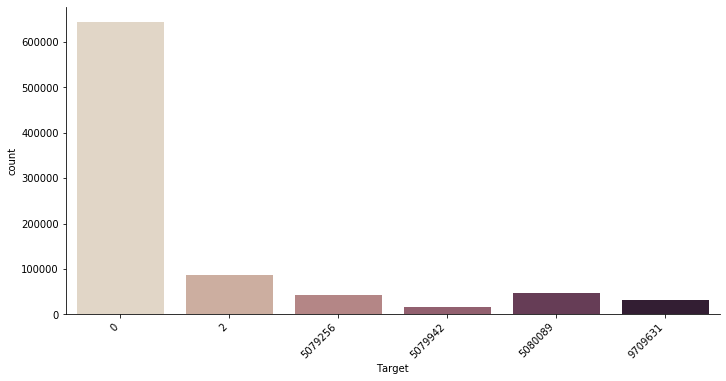

In [0]:
ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=df_no_exit,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

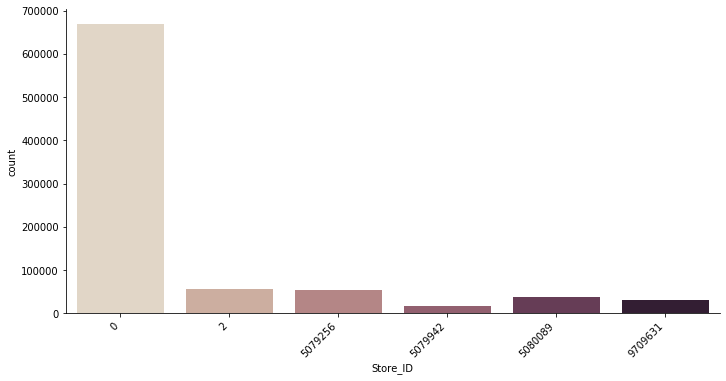

In [0]:
ax = sns.catplot(x="Store_ID", kind="count", palette="ch:.25", data=df_no_exit,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

In [0]:
df_no_exit_wo_seq = df_no_exit

In [0]:
df_no_exit_wo_seq.sort_values(by=['DateTime','Customer_ID','Sequence_Num'])

,DateTime,Customer_ID,Sequence_Num,Store_ID,Dwell_Time,Day,Month,Next_Sequence,Target,Time,Category_ID
0,2018-01-01 10:03:50,26,1,0,35,0.0,1.0,2.0,0,10:03:50,14
280254,2018-01-01 10:08:50,29,1,5079256,27,0.0,1.0,2.0,5080089,10:08:50,8
368274,2018-01-01 10:10:50,30,1,0,9,0.0,1.0,2.0,9709631,10:10:50,8
443955,2018-01-01 10:11:20,31,1,0,44,0.0,1.0,2.0,5079256,10:11:20,15
172484,2018-01-01 10:18:50,32,1,5080089,45,0.0,1.0,2.0,2,10:18:50,8
...,...,...,...,...,...,...,...,...,...,...,...
1531559,2018-06-30 20:44:40,441759,2,0,12,5.0,6.0,3.0,0,20:44:40,14
172477,2018-06-30 20:46:00,534438,1,2,26,5.0,6.0,2.0,0,20:46:00,8
1171366,2018-06-30 20:49:40,534443,1,0,10,5.0,6.0,2.0,0,20:49:40,8
675520,2018-06-30 20:53:40,534444,1,0,6,5.0,6.0,2.0,0,20:53:40,8


Performing a Stratfied shuffle split to make sure the distribution between train and test set remains the same as we split it to get the dataset ready for training a model

In [0]:
split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

for train_index, test_index in split.split(df_no_exit_wo_seq, df_no_exit_wo_seq['Target']):
  strat_train_stores_wo_seq = df_no_exit_wo_seq.iloc[train_index]
  strat_test_stores_wo_seq = df_no_exit_wo_seq.iloc[test_index]

The distribution of train/test split is identical but there is a huge imbalance in the classes

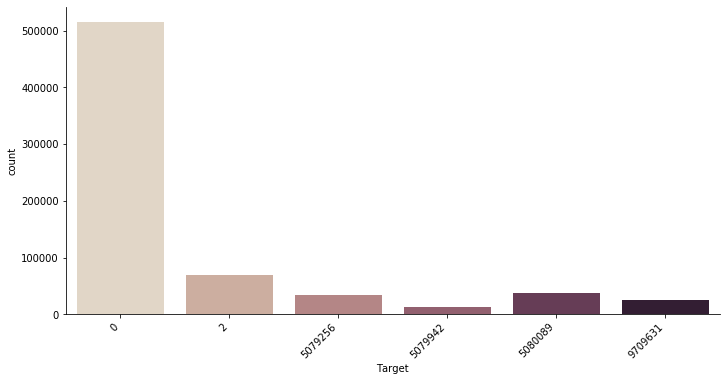

In [0]:
ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=strat_train_stores_wo_seq,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

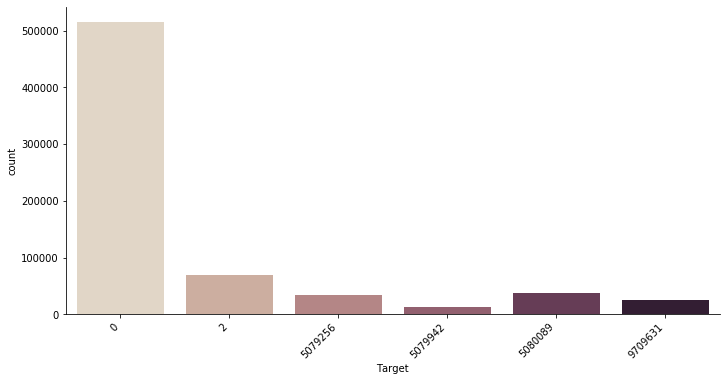

In [0]:
ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=strat_train_stores_wo_seq,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

Splitting the data set into test/train. Also extracting the target column out for training the model

In [0]:
X_train_store_wo_seq = strat_train_stores_wo_seq[['Customer_ID', 'Sequence_Num', 'Store_ID', 'Dwell_Time','Day', 'Month', 'Category_ID']]
y_train_store_wo_seq = strat_train_stores_wo_seq[['Target']]
X_test_store_wo_seq = strat_test_stores_wo_seq[['Customer_ID', 'Sequence_Num', 'Store_ID', 'Dwell_Time','Day', 'Month', 'Category_ID']]
y_test_store_wo_seq = strat_test_stores_wo_seq[['Target']]

Training a Random Forest Classfier

In [0]:
rnd_clf_wo_seq = RandomForestClassifier(n_estimators=500, max_depth=15,n_jobs=-1,random_state=5,criterion='entropy')
rnd_clf_wo_seq.fit(X_train_store_wo_seq,y_train_store_wo_seq)

Train and Test Accuracy

In [0]:
score = rnd_clf_wo_seq.score(X_train_store_wo_seq, y_train_store_wo_seq)
score2 = rnd_clf_wo_seq.score(X_test_store_wo_seq, y_test_store_wo_seq)

print("Training set accuracy: ", '%.3f'%(score))
print("Test set accuracy: ", '%.3f'%(score2))

Training set accuracy:  0.744
Test set accuracy:  0.744


Metrics broken down by mult-class. This is expected as the training set is hugely imbalanced for class 'others' our algorthim learns absoluetly nothing

In [0]:
y_pred_stores_wo_seq = rnd_clf_wo_seq.predict(X_test_store_wo_seq)
print(classification_report(y_test_store_wo_seq,y_pred_stores_wo_seq))

              precision    recall  f1-score   support

           0       0.74      1.00      0.85    129044
           2       0.00      0.00      0.00     17164
     5079256       0.00      0.00      0.00      8394
     5079942       0.00      0.00      0.00      3297
     5080089       0.00      0.00      0.00      9172
     9709631       0.00      0.00      0.00      6305

    accuracy                           0.74    173376
   macro avg       0.12      0.17      0.14    173376
weighted avg       0.55      0.74      0.64    173376



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



The distribution of 'other' stores is highly skewed and during training there would be a risk off overfitting on the majority class. As a result we will perform downsampling on the training data. We have wnough number of instances for us to downsample the data. We will resample without replacement and reduce the sample of overweighted class to match one of the minority class

In [0]:
df_exit_no_seq = df_no_exit

Performing a Stratfied shuffle split to make sure the distribution between train and test set remains the same as we split it to get the dataset ready for training a model

In [0]:
split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

for train_index, test_index in split.split(df_exit_no_seq, df_exit_no_seq['Target']):
  strat_train_stores_no_seq = df_exit_no_seq.iloc[train_index]
  strat_test_stores_no_seq = df_exit_no_seq.iloc[test_index]

The distribution of 'other' stores is highly skewed and during training there would be a risk off overfitting on the majority class. As a result we will perform downsampling on the training data. We have wnough number of instances for us to downsample the data. We will resample without replacement and reduce the sample of overweighted class to match one of the minority class

In [0]:
df_majority_no_seq = strat_train_stores_no_seq[strat_train_stores_no_seq['Target']==0]
df_minority_no_seq = strat_train_stores_no_seq[strat_train_stores_no_seq['Target']==5079942]


df_majority_downsampled_no_seq = resample(df_majority_no_seq, 
                                 replace=False,     
                                 n_samples=len(df_minority_no_seq),   
                                 random_state=42) 

In [0]:
strat_train_stores_no_seq = strat_train_stores_no_seq[strat_train_stores_no_seq['Target']!=0]
strat_train_stores_no_seq = pd.concat([df_majority_downsampled_no_seq, strat_train_stores_no_seq])
strat_train_stores_no_seq = shuffle(strat_train_stores_no_seq)

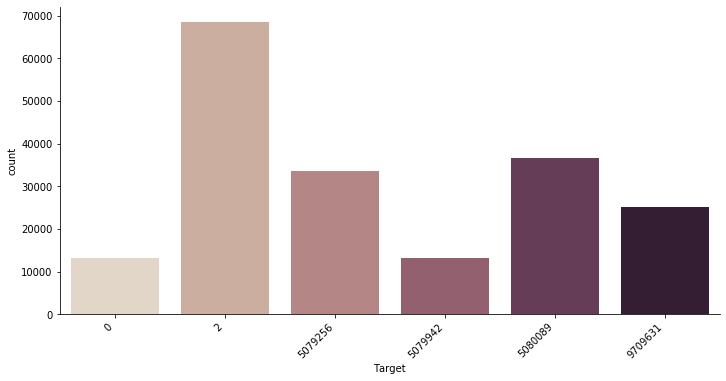

In [0]:
ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=strat_train_stores_no_seq,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

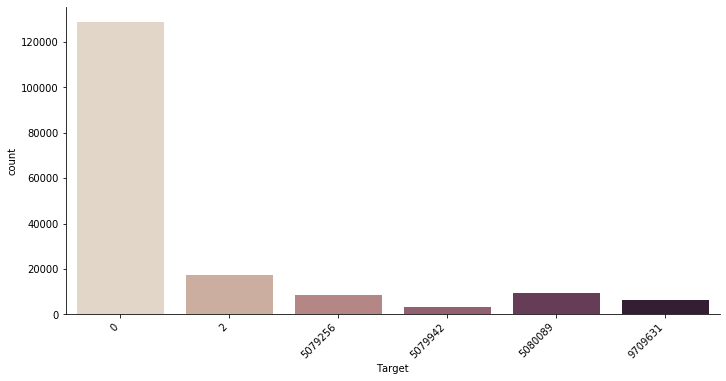

In [0]:
ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=strat_test_stores_no_seq,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')


Splitting the data set into test/train. Also extracting the target column out for training the model

In [0]:
X_train_store_no_seq = strat_train_stores_no_seq[['Customer_ID', 'Sequence_Num', 'Store_ID', 'Dwell_Time','Day', 'Month', 'Category_ID']]
y_train_store_no_seq = strat_train_stores_no_seq[['Target']]
X_test_store_no_seq = strat_test_stores_no_seq[['Customer_ID', 'Sequence_Num', 'Store_ID', 'Dwell_Time','Day', 'Month', 'Category_ID']]
y_test_store_no_seq = strat_test_stores_no_seq[['Target']]

Training a random forest classifier

In [0]:
rnd_clf_no_seq = RandomForestClassifier(n_estimators=500, max_depth=15,n_jobs=-1,random_state=5,criterion='entropy')
rnd_clf_no_seq.fit(X_train_store_no_seq,y_train_store_no_seq)

Global level Train/Test Accuracy

In [0]:
score = rnd_clf_no_seq.score(X_train_store_no_seq, y_train_store_no_seq)
score2 = rnd_clf_no_seq.score(X_test_store_no_seq, y_test_store_no_seq)

print("Training set accuracy: ", '%.3f'%(score))
print("Test set accuracy: ", '%.3f'%(score2))

Training set accuracy:  0.547
Test set accuracy:  0.129


Multilabel Test Accuracy broken down by classes

In [0]:
y_pred_stores_no_seq = rnd_clf_no_seq.predict(X_test_store_no_seq)
print(classification_report(y_test_store_no_seq,y_pred_stores_no_seq))

              precision    recall  f1-score   support

           0       0.89      0.00      0.01    129044
           2       0.12      0.82      0.20     17164
     5079256       0.09      0.22      0.13      8394
     5079942       0.63      0.67      0.65      3297
     5080089       0.11      0.24      0.15      9172
     9709631       0.19      0.23      0.21      6305

    accuracy                           0.13    173376
   macro avg       0.34      0.36      0.22    173376
weighted avg       0.71      0.13      0.06    173376



#An additional signal using Sequence and taking into account a customer's history until that point

In [0]:
df_no_exit_w_seq = df_no_exit

In [0]:
df_one_hot = pd.get_dummies(df_no_exit['Store_ID'])
df_no_exit_w_seq= df_no_exit_w_seq.join(df_one_hot)
df_no_exit_w_seq =df_no_exit_w_seq[['Customer_ID','Store_ID','Dwell_Time','Day','Sequence_Num','Category_ID','Month', 0, 2, 5079256, 5079942 ,5080089,9709631,'Target']]

In [0]:
df_no_exit_w_seq.sort_values(by=['Day','Month','Customer_ID','Sequence_Num'])

,Customer_ID,Store_ID,Dwell_Time,Day,Sequence_Num,Category_ID,Month,0,2,5079256,5079942,5080089,9709631,Target
0,26,0,35,0.0,1,14,1.0,1,0,0,0,0,0,0
280254,29,5079256,27,0.0,1,8,1.0,0,0,1,0,0,0,5080089
368274,30,0,9,0.0,1,8,1.0,1,0,0,0,0,0,9709631
443955,31,0,44,0.0,1,15,1.0,1,0,0,0,0,0,5079256
172484,32,5080089,45,0.0,1,8,1.0,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530343,520172,0,6,6.0,1,6,6.0,1,0,0,0,0,0,9709631
441935,520172,9709631,51,6.0,2,8,6.0,0,0,0,0,0,1,0
641192,520172,0,9,6.0,3,4,6.0,1,0,0,0,0,0,0
983124,520176,0,18,6.0,1,7,6.0,1,0,0,0,0,0,0


Now we will track the sequence of stores as the customer moves from one store to the next. The sequence would reset as the customer leaves the store.

In [0]:
df_sequence = df_no_exit_w_seq.groupby(by=['Day','Month','Customer_ID'])[0,2,5079256, 5079942 ,5080089,9709631].cumsum(axis=0) # Tracking the sequence using cumalative sum
df_no_exit_w_seq.drop(columns=[0,2,5079256, 5079942 ,5080089,9709631],axis=0,inplace=True)
df_no_exit_w_seq = df_no_exit_w_seq.merge(df_sequence,how='inner',left_index=True,right_index=True)

Performing a Stratfied shuffle split to make sure the distribution between train and test set remains the same as we split it to get the dataset ready for training a model

In [0]:
split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

for train_index, test_index in split.split(df_no_exit_w_seq, df_no_exit_w_seq['Target']):
  strat_train_stores = df_no_exit_w_seq.iloc[train_index]
  strat_test_stores = df_no_exit_w_seq.iloc[test_index]

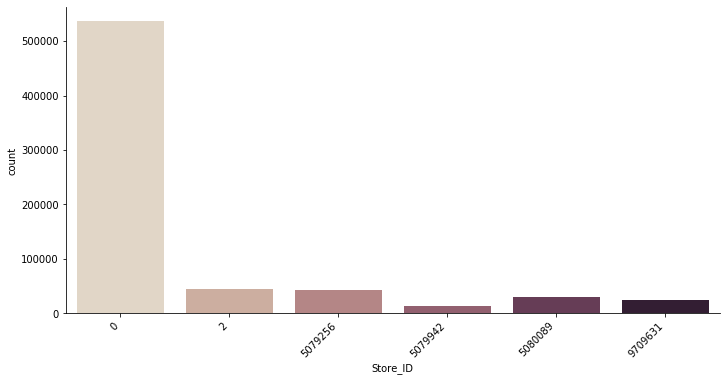

In [0]:
ax = sns.catplot(x="Store_ID", kind="count", palette="ch:.25", data=strat_train_stores,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

The distribution of 'other' stores is highly skewed and during training there would be a risk off overfitting on the majority class. As a result we will perform downsampling on the training data. We have wnough number of instances for us to downsample the data. We will resample without replacement and reduce the sample of overweighted class to match one of the minority class

In [0]:
df_majority = strat_train_stores[strat_train_stores['Target']==0]
df_minority = strat_train_stores[strat_train_stores['Target']==5079942]


df_majority_downsampled = resample(df_majority, 
                                 replace=False,     
                                 n_samples=len(df_minority),   
                                 random_state=42) 

In [0]:
strat_train_stores = strat_train_stores[strat_train_stores['Target']!=0]
strat_train_stores = pd.concat([df_majority_downsampled, strat_train_stores])
strat_train_stores = shuffle(strat_train_stores)

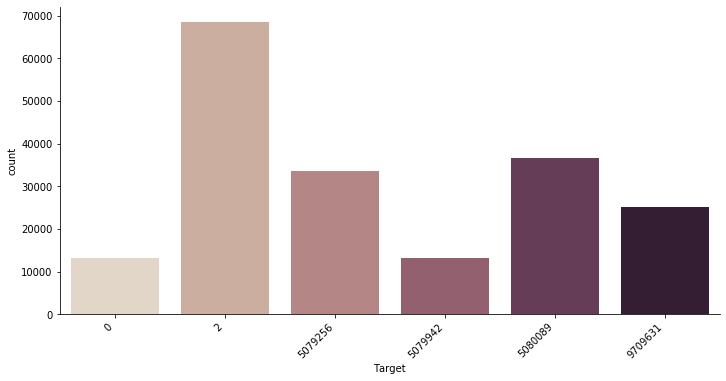

In [0]:
ax = sns.catplot(x="Target", kind="count", palette="ch:.25", data=strat_train_stores,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

Splitting the data set into test/train. Also extracting the target column out for training the model

In [0]:
X_train_store = strat_train_stores[['Day','Month','Dwell_Time',0, 2, 5079256, 5079942 ,5080089,9709631]]
y_train_store = strat_train_stores[['Target']]
X_test_store = strat_test_stores[['Day','Month','Dwell_Time',0, 2, 5079256, 5079942 ,5080089,9709631]]
y_test_store = strat_test_stores[['Target']]

Training a Random Forest Classfier 

In [0]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=25,n_jobs=-1,random_state=15,criterion='entropy')
rnd_clf.fit(X_train_store,y_train_store)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

In [0]:
y_pred_stores = rnd_clf.predict(X_test_store)

In [0]:
f1 = f1_score(y_test_store, y_pred_stores,average='macro')
print("Test set F1-Score: ", '%.3f'%(f1))

Test set F1-Score:  0.306


In [0]:

print(classification_report(y_test_store,y_pred_stores))

              precision    recall  f1-score   support

           0       0.88      0.06      0.12    129044
           2       0.15      0.77      0.24     17164
     5079256       0.18      0.56      0.28      8394
     5079942       0.59      0.80      0.68      3297
     5080089       0.15      0.47      0.23      9172
     9709631       0.21      0.47      0.29      6305

    accuracy                           0.21    173376
   macro avg       0.36      0.52      0.31    173376
weighted avg       0.71      0.21      0.16    173376



We can extract the importance of our feature set as shown below. Higher the importance greater the feature plays a role in classifying the different classes

In [0]:
cols = X_train_store.columns
feature_importance_all = rnd_clf.feature_importances_
feature_importance = {}
for i in  range(len(cols)):
    feature_importance[cols[i]] = feature_importance_all[i]

feature_import =  pd.DataFrame.from_dict(feature_importance, 
                                         orient = 'index',columns=['Importance'])
feature_import.sort_values(by='Importance',ascending=False)

,Importance
Dwell_Time,0.273317
5079942,0.150189
0,0.123867
5079256,0.111932
9709631,0.088227
Day,0.070483
5080089,0.069800
Month,0.056733
2,0.055452


# One more added signal by tracking the dwell time as the customer moves from one store to the next

In [0]:
df_extra_dwell = df_no_exit.pivot_table(values=['Dwell_Time'],index=['DateTime','Customer_ID','Sequence_Num'],columns=['Store_ID']).fillna(0).sort_values(by=['Customer_ID'])
df_extra_dwell.reset_index(inplace = True)

In [0]:
df_no_exit_dwell = df_no_exit_w_seq.merge(df_extra_dwell,how='inner', on='Customer_ID')

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [0]:
split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

for train_index, test_index in split.split(df_no_exit_dwell, df_no_exit_dwell['Target']):
  strat_train_stores = df_no_exit_dwell.iloc[train_index]
  strat_test_stores = df_no_exit_dwell.iloc[test_index]

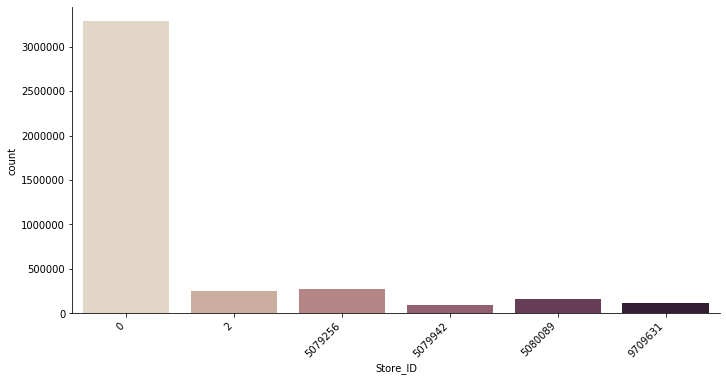

In [0]:
ax = sns.catplot(x="Store_ID", kind="count", palette="ch:.25", data=strat_train_stores,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

In [0]:
df_majority = strat_train_stores[strat_train_stores['Target']==0]
df_minority = strat_train_stores[strat_train_stores['Target']==5079942]


df_majority_downsampled = resample(df_majority, 
                                 replace=False,     
                                 n_samples=len(df_minority),   
                                 random_state=42) 

In [0]:
strat_train_stores = strat_train_stores[strat_train_stores['Target']!=0]
strat_train_stores = pd.concat([df_majority_downsampled, strat_train_stores])
strat_train_stores = shuffle(strat_train_stores)

In [0]:
X_train_store = strat_train_stores[['Day','Category_ID','Month', 0,2,5079256,5079942,5080089,9709631,('Dwell_Time', 0),('Dwell_Time', 2),('Dwell_Time', 5079256), ('Dwell_Time', 5079942),('Dwell_Time', 5080089), ('Dwell_Time', 9709631)]]
y_train_store = strat_train_stores[['Target']]
X_test_store = strat_test_stores[['Day','Category_ID','Month', 0,2,5079256,5079942,5080089,9709631,('Dwell_Time', 0),('Dwell_Time', 2),('Dwell_Time', 5079256), ('Dwell_Time', 5079942),('Dwell_Time', 5080089), ('Dwell_Time', 9709631)]]
y_test_store = strat_test_stores[['Target']]

In [0]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=25,n_jobs=-1,random_state=15,criterion='entropy')
rnd_clf.fit(X_train_store,y_train_store)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

In [0]:
y_pred_stores = rnd_clf.predict(X_test_store)

In [0]:
f1 = f1_score(y_test_store, y_pred_stores,average='macro')
print("Test set F1-Score: ", '%.3f'%(f1))

Test set F1-Score:  0.357


In [0]:

print(classification_report(y_test_store,y_pred_stores))

              precision    recall  f1-score   support

           0       0.96      0.11      0.20    797748
           2       0.16      0.82      0.27     95982
     5079256       0.21      0.75      0.33     53311
     5079942       0.56      0.87      0.68     21543
     5080089       0.18      0.66      0.28     46553
     9709631       0.26      0.62      0.37     29503

    accuracy                           0.27   1044640
   macro avg       0.39      0.64      0.36   1044640
weighted avg       0.78      0.27      0.24   1044640



# Removing all customers who only go to one store and we do not have a history available

In [0]:
df_two_or_more = df_no_exit_dwell[df_no_exit_dwell.duplicated('Customer_ID', keep= False)]

In [0]:
split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

for train_index, test_index in split.split(df_two_or_more, df_two_or_more['Target']):
  strat_train_stores = df_two_or_more.iloc[train_index]
  strat_test_stores = df_two_or_more.iloc[test_index]

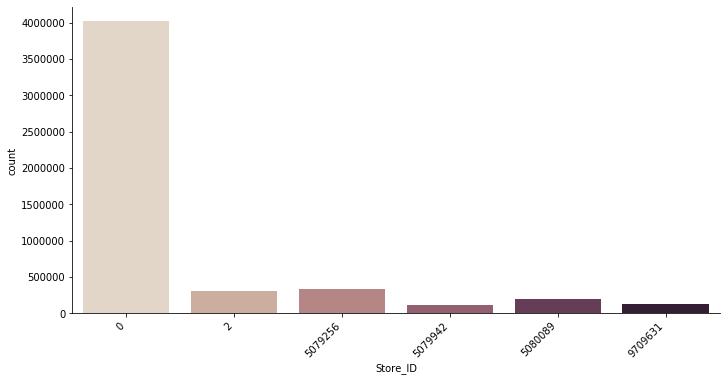

In [0]:
ax = sns.catplot(x="Store_ID", kind="count", palette="ch:.25", data=df_two_or_more,height=5, aspect=2)
ax.set_xticklabels( rotation=45, horizontalalignment='right')

In [0]:
df_majority = strat_train_stores[strat_train_stores['Target']==0]
df_minority = strat_train_stores[strat_train_stores['Target']==5079942]


df_majority_downsampled = resample(df_majority, 
                                 replace=False,     
                                 n_samples=len(df_minority),   
                                 random_state=42) 

In [0]:
strat_train_stores = strat_train_stores[strat_train_stores['Target']!=0]
strat_train_stores = pd.concat([df_majority_downsampled, strat_train_stores])
strat_train_stores = shuffle(strat_train_stores)

In [0]:
X_train_store = strat_train_stores[['Day','Category_ID','Month', 0,2,5079256,5079942,5080089,9709631,('Dwell_Time', 0),('Dwell_Time', 2),('Dwell_Time', 5079256), ('Dwell_Time', 5079942),('Dwell_Time', 5080089), ('Dwell_Time', 9709631)]]
y_train_store = strat_train_stores[['Target']]
X_test_store = strat_test_stores[['Day','Category_ID','Month', 0,2,5079256,5079942,5080089,9709631,('Dwell_Time', 0),('Dwell_Time', 2),('Dwell_Time', 5079256), ('Dwell_Time', 5079942),('Dwell_Time', 5080089), ('Dwell_Time', 9709631)]]
y_test_store = strat_test_stores[['Target']]

In [0]:
rnd_clf = RandomForestClassifier(n_estimators=200, max_depth=25,n_jobs=-1,random_state=15,criterion='entropy')
rnd_clf.fit(X_train_store,y_train_store)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

In [0]:
y_pred_stores = rnd_clf.predict(X_test_store)

In [0]:
f1 = f1_score(y_test_store, y_pred_stores,average='macro')
print("Test set F1-Score: ", '%.3f'%(f1))

Test set F1-Score:  0.359


In [0]:
print(classification_report(y_test_store,y_pred_stores))

              precision    recall  f1-score   support

           0       0.96      0.12      0.21    781048
           2       0.16      0.83      0.27     93274
     5079256       0.21      0.76      0.33     52188
     5079942       0.55      0.87      0.67     21240
     5080089       0.19      0.67      0.29     44670
     9709631       0.26      0.63      0.37     28536

    accuracy                           0.27   1020956
   macro avg       0.39      0.65      0.36   1020956
weighted avg       0.78      0.27      0.24   1020956



# Adding one more signal where we are tracking the total time spent by a customers over the entire dataset

In [0]:
df_extra_dwell_total = df_no_exit.pivot_table(values=['Dwell_Time'],index=['Customer_ID'],columns=['Store_ID']).fillna(0).sort_values(by=['Customer_ID'])
df_extra_dwell_total.reset_index(inplace = True)

In [0]:
df_no_exit_dwell_total = df_no_exit_dwell.merge(df_extra_dwell_total,how='left', on='Customer_ID')

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [0]:
split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=1)

for train_index, test_index in split.split(df_no_exit_dwell_total, df_no_exit_dwell_total['Target']):
  strat_train_stores = df_no_exit_dwell_total.iloc[train_index]
  strat_test_stores = df_no_exit_dwell_total.iloc[test_index]

In [0]:
df_majority = strat_train_stores[strat_train_stores['Target']==0]
df_minority = strat_train_stores[strat_train_stores['Target']==5079942]


df_majority_downsampled = resample(df_majority, 
                                 replace=False,     
                                 n_samples=len(df_minority),   
                                 random_state=42) 

In [0]:
strat_train_stores = strat_train_stores[strat_train_stores['Target']!=0]
strat_train_stores = pd.concat([df_majority_downsampled, strat_train_stores])
strat_train_stores = shuffle(strat_train_stores)

In [0]:
strat_test_stores.columns

Index([              'Customer_ID',                  'Store_ID',
                    'Dwell_Time_x',                       'Day',
                    'Sequence_Num',               'Category_ID',
                           'Month',                    'Target',
                                 0,                           2,
                           5079256,                     5079942,
                           5080089,                     9709631,
                  ('DateTime', ''),        ('Sequence_Num', ''),
             '('Dwell_Time', 0)_x',       '('Dwell_Time', 2)_x',
       '('Dwell_Time', 5079256)_x', '('Dwell_Time', 5079942)_x',
       '('Dwell_Time', 5080089)_x', '('Dwell_Time', 9709631)_x',
               ('Dwell_Time_y', 0),         ('Dwell_Time_y', 2),
         ('Dwell_Time_y', 5079256),   ('Dwell_Time_y', 5079942),
         ('Dwell_Time_y', 5080089),   ('Dwell_Time_y', 9709631)],
      dtype='object')

In [0]:
X_train_store = strat_train_stores[['Day','Category_ID','Month', 0,2, 5079256, 5079942, 5080089, 9709631,"('Dwell_Time', 0)_x", "('Dwell_Time', 2)_x","('Dwell_Time', 5079256)_x", "('Dwell_Time', 5079942)_x","('Dwell_Time', 5080089)_x", "('Dwell_Time', 9709631)_x",('Dwell_Time_y', 0),('Dwell_Time_y', 2),('Dwell_Time_y', 5079256), ('Dwell_Time_y', 5079942),('Dwell_Time_y', 5080089),   ('Dwell_Time_y', 9709631)]]
y_train_store = strat_train_stores[['Target']]
X_test_store = strat_test_stores[['Day','Category_ID','Month', 0,2, 5079256, 5079942, 5080089, 9709631,"('Dwell_Time', 0)_x", "('Dwell_Time', 2)_x","('Dwell_Time', 5079256)_x", "('Dwell_Time', 5079942)_x","('Dwell_Time', 5080089)_x", "('Dwell_Time', 9709631)_x",('Dwell_Time_y', 0),('Dwell_Time_y', 2),('Dwell_Time_y', 5079256), ('Dwell_Time_y', 5079942),('Dwell_Time_y', 5080089),   ('Dwell_Time_y', 9709631)]]
y_test_store = strat_test_stores[['Target']]

In [0]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=25,n_jobs=-1,random_state=15,criterion='entropy')
rnd_clf.fit(X_train_store,y_train_store)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

In [0]:
y_pred_stores = rnd_clf.predict(X_test_store)

In [0]:
f1 = f1_score(y_test_store, y_pred_stores,average='macro')
print("Test set F1-Score: ", '%.3f'%(f1))

Test set F1-Score:  0.486


In [0]:
print(classification_report(y_test_store,y_pred_stores))

              precision    recall  f1-score   support

           0       1.00      0.29      0.45    797748
           2       0.23      0.94      0.37     95982
     5079256       0.30      0.91      0.45     53311
     5079942       0.57      1.00      0.73     21543
     5080089       0.28      0.86      0.42     46553
     9709631       0.36      0.84      0.50     29503

    accuracy                           0.44   1044640
   macro avg       0.45      0.81      0.49   1044640
weighted avg       0.83      0.44      0.45   1044640



In [0]:
cols = X_train_store.columns
feature_importance_all = rnd_clf.feature_importances_
feature_importance = {}
for i in  range(len(cols)):
    feature_importance[cols[i]] = feature_importance_all[i]

feature_import =  pd.DataFrame.from_dict(feature_importance, 
                                         orient = 'index',columns=['Importance'])
feature_import.sort_values(by='Importance',ascending=False)

,Importance
0,0.092907
"(Dwell_Time_y, 0)",0.089808
5079942,0.080596
"(Dwell_Time_y, 5079256)",0.076544
5079256,0.074913
"(Dwell_Time_y, 5079942)",0.074478
Category_ID,0.073891
"(Dwell_Time_y, 2)",0.059975
"(Dwell_Time_y, 5080089)",0.057622
"(Dwell_Time_y, 9709631)",0.052744


# Now we will train a feed forward Neural Network with all the signals we have processed

In [0]:
y_train_store = pd.get_dummies(y_train_store['Target'])


In [0]:
y_test_store = pd.get_dummies(y_test_store['Target'])

In [0]:
classifier = tf.keras.Sequential()
#First Hidden Layer
classifier.add(tf.keras.layers.Dense(18, activation='relu', kernel_initializer='random_normal', input_dim=21))
#Second  Hidden Layer
classifier.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer='random_normal'))
#Second  Hidden Layer
classifier.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer='random_normal'))
#Second  Hidden Layer
classifier.add(tf.keras.layers.Dense(12, activation='relu', kernel_initializer='random_normal'))

#Output Layer
classifier.add(tf.keras.layers.Dense(6, activation='softmax', kernel_initializer='random_normal'))

In [0]:
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='categorical_crossentropy',metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),'accuracy'])

In [0]:
#Fitting the data to the training dataset
history = classifier.fit(X_train_store,y_train_store, batch_size=1024, epochs=50, validation_data=[X_test_store,y_test_store])

Train on 1073739 samples, validate on 1044640 samples
Epoch 1/50
1073739/1073739 [==============================] - 7s 7us/sample - loss: 1.2374 - precision_4: 0.6520 - recall_4: 0.3054 - acc: 0.5237 - val_loss: 2.0638 - val_precision_4: 0.2035 - val_recall_4: 0.1073 - val_acc: 0.1467
Epoch 2/50
1073739/1073739 [==============================] - 6s 5us/sample - loss: 1.0897 - precision_4: 0.6918 - recall_4: 0.4348 - acc: 0.5868 - val_loss: 1.9919 - val_precision_4: 0.2308 - val_recall_4: 0.1178 - val_acc: 0.1567
Epoch 3/50
1073739/1073739 [==============================] - 6s 5us/sample - loss: 1.0083 - precision_4: 0.7473 - recall_4: 0.4832 - acc: 0.6279 - val_loss: 1.9249 - val_precision_4: 0.2653 - val_recall_4: 0.1271 - val_acc: 0.1649
Epoch 4/50
1073739/1073739 [==============================] - 6s 5us/sample - loss: 0.9732 - precision_4: 0.7624 - recall_4: 0.5000 - acc: 0.6413 - val_loss: 1.8982 - val_precision_4: 0.2660 - val_recall_4: 0.1307 - val_acc: 0.1674
Epoch 5/50
1073739

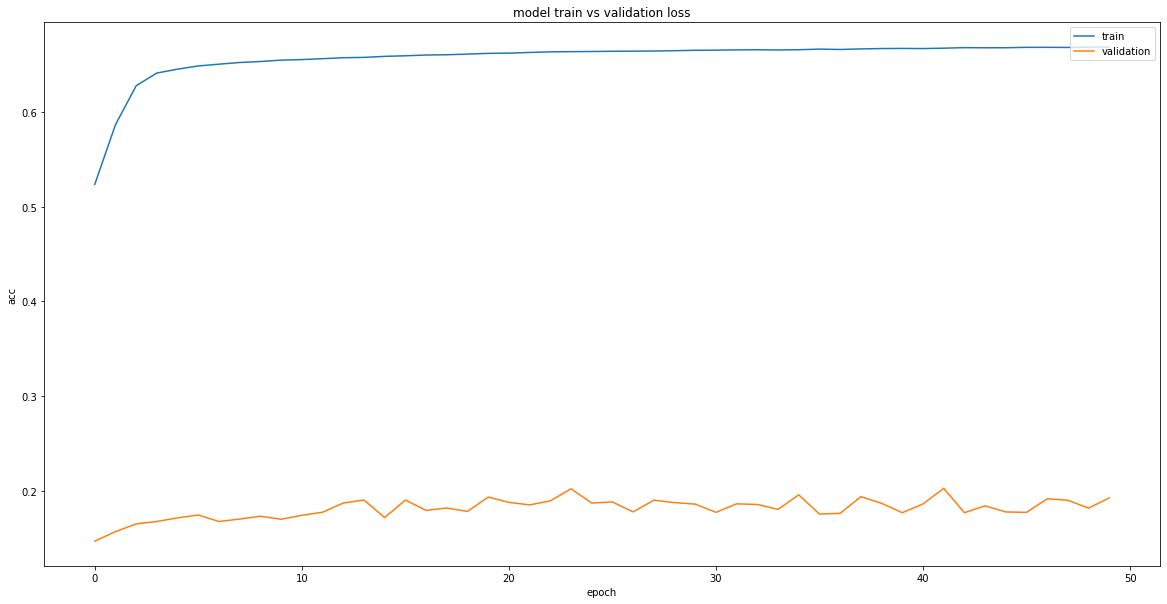

In [0]:
plt.figure(figsize=(20,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation loss')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc ='upper right')
plt.show()

In [0]:
# evaluate model with keras
score = classifier.evaluate(X_test_store, y_test_store, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])

Test score: 1.8035902849582421
Test accuracy: 0.26979527
Test precision: 0.14455602
Test recall: 0.19239834
